# Machine Learning Models and Dimensionality Reduction for Prediction of Polymer Properties

This notebook demonstrates how to predict polymer properties using machine learning, focusing on feature engineering and dimensionality reduction. The analysis replicates results from [this study](https://pubs.acs.org/doi/10.1021/acs.macromol.3c02401).

*Abstract*

Accurate prediction of block polymer properties as a function of monomer sequence is necessary for better material development. The number of permutations of chemistry and sequence is nearly infinite, and new methods are needed to predict and engineer properties as a function of molecular structure. In this work, we present a machine learning approach to determine polymer properties where a feed-forward neural network is trained to predict the period length of a diblock lamellar system as a function of block sequence and interaction parameters. These sequenced polymers are similar to experimentally explored polypeptoid systems. Additionally, we report on our efforts to explore dimensionality reduction as a method for gaining physical insights into these polymeric materials. 


The image below provides a visual representation of lamellar period. It highlights the relationship between the lamellar period and the volume fraction in block polymers.


In [97]:
Image(url= "https://pubs.acs.org/cms/10.1021/acs.macromol.3c02401/asset/images/medium/ma3c02401_0010.gif")


In [98]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from sklearn.ensemble import RandomForestRegressor  # ML model for prediction
from sklearn.model_selection import train_test_split  # For splitting data
import os  # File path operations
import pandas as pd  # Data manipulation


We load the raw data files containing polymer sequences and their properties. Each dataset represents a specific experimental condition. The data includes columns such as:
- `sequence`: Polymer sequence
- `alpha_BC`: The interaction between beads given by the following expression $\epsilon_{ij} = \epsilon_{ii} + \alpha_{ij}$ where $i=B$ and $j=C$
- `property`: Target property for prediction


In [99]:

RawData = os.path.join('RawData', 'Data_1')
df = pd.read_csv(RawData, sep='  ')
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_17092\1831448075.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(RawData, sep='  ')


,sequence,lamella_period,alpha_BC
0,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,15.267611,0.0
1,CCCBBBBBBCCCCBCCCCCCCCCBBBBBBBBB,15.907098,0.0
2,BBBBBCCCBCCCCBBBBBBBBBBBBBBBBBBB,15.554056,0.0
3,BBCBBBCCCCCBBBBBBBBBCBBBBBBBBBBB,15.514686,0.0
4,CCCCBBBBBBBBBCCCCCCCCBBBBBBBCBBB,15.783591,0.0


In [100]:
#Load the rest of the data
RawData2 = os.path.join('RawData', 'Data_2')
df2 = pd.read_csv(RawData2, sep='  ')
RawData3 = os.path.join('RawData', 'Data_3')
df3 = pd.read_csv(RawData3, sep='  ')
RawData4 = os.path.join('RawData', 'Data_4')
df4 = pd.read_csv(RawData4, sep='  ')

C:\Users\USER\AppData\Local\Temp\ipykernel_17092\2720579981.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df2 = pd.read_csv(RawData2, sep='  ')
C:\Users\USER\AppData\Local\Temp\ipykernel_17092\2720579981.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df3 = pd.read_csv(RawData3, sep='  ')
C:\Users\USER\AppData\Local\Temp\ipykernel_17092\2720579981.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df4

#

### Feature Engineering
We extract key features from the polymer sequences:
1. **Fraction of B**: Proportion of a specific block in the sequence.
2. **Sequence Vectors**: Numerical representation of sequences for ML models.

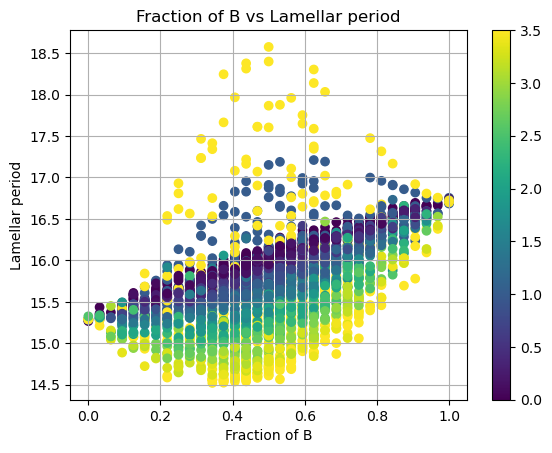

In [101]:
#Calculate fraction of B in sequence
def fraction_B(seq):
    return 1-seq.count('B') / len(seq)
#Transform sequence into vector of numbers
def seq_to_vec(seq):
    seq_dict = {'B': 0, 'C': 1}
    vec = np.zeros((len(seq), 4))
    for i, base in enumerate(seq):
        vec[i, seq_dict[base]] = 1
    return vec.flatten()
#Merge all data
df_total = pd.concat([df, df2, df3, df4])
#Add to dataset
df_total['fraction_B'] = df_total['sequence'].apply(fraction_B)

#Plot fraction of B vs lamella period
plt.scatter(df_total['fraction_B'], df_total['lamella_period'],c=df_total['alpha_BC'], cmap='viridis')
cbar = plt.colorbar()
plt.xlabel('Fraction of B')
plt.ylabel('Lamellar period')
plt.grid(True)
plt.title('Fraction of B vs Lamellar period')
plt.show()



### Model Training and Visualization
We use a Random Forest Regressor to predict polymer properties based on the engineered features. The plots below compare the predicted and true values, with `alpha_BC` encoded as color to visualize its effect.


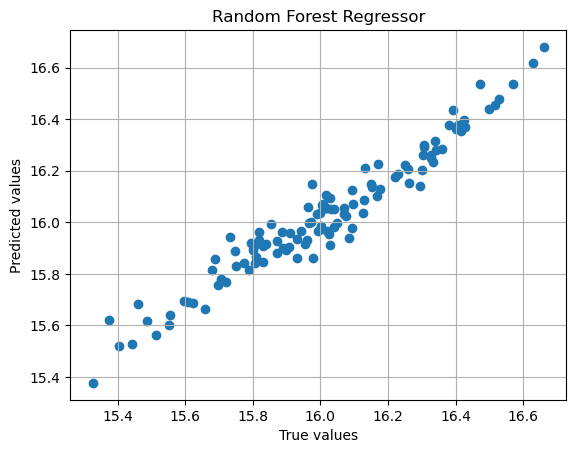

MSE: 0.006448905675145999
R2: 0.922716098568037
MSE: 0.002082768043736832
R2: 0.9767821909184985


In [108]:


#Transform sequences into vectors
X = np.array([seq_to_vec(seq) for seq in df['sequence']])
y = df['lamella_period'].values

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Train random forest regressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

#Predict on test set
y_pred = clf.predict(X_test)

#Plot predicted vs true values
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.title('Random Forest Regressor')
plt.show()

#Get performance metrics
from sklearn.metrics import mean_squared_error, r2_score
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))




In [109]:

#Transform sequences into vectors
X = np.array([seq_to_vec(seq) for seq in df_total['sequence']])
# Concat alpha_BC with X
X = np.concatenate((X, df_total['alpha_BC'].values.reshape(-1, 1)), axis=1)
y = df_total['lamella_period'].values

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Train random forest regressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

#Predict on test set
y_pred = clf.predict(X_test)


print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MSE: 0.038641389489657584
R2: 0.8678960230518773


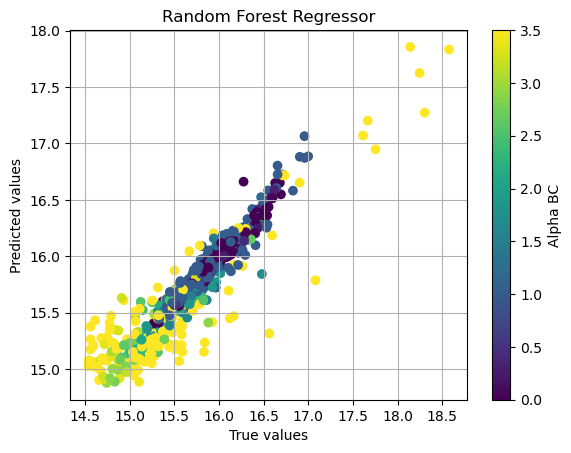

In [104]:
#Plot predicted vs true values
#Use alpha BC as color
plt.scatter(y_test, y_pred, c=X_test[:, -1], cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('Alpha BC')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.title('Random Forest Regressor')
plt.show()

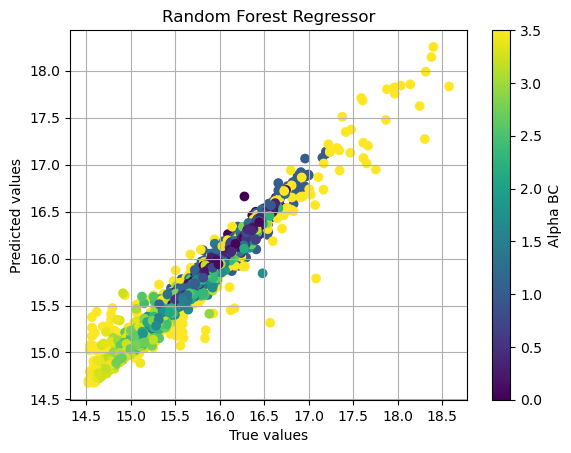

In [105]:
#Plot all data
y_pred = clf.predict(X)
plt.scatter(y, y_pred, c=X[:, -1], cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('Alpha BC')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.title('Random Forest Regressor')
plt.show()
